# Compressive Sensing Image Reconstruction

This notebook implements compressive sensing (CS) image reconstruction using the L-BFGS optimizer.

After installing the required packages, please restart the kernel before running the code.


Processing sampling ratio 0.50
Channel 1/3: Running L-BFGS-B optimization...
Channel 2/3: Running L-BFGS-B optimization...
Channel 2/3: Running L-BFGS-B optimization...
Channel 3/3: Running L-BFGS-B optimization...
Channel 3/3: Running L-BFGS-B optimization...
PSNR: 4.68 dB
SSIM: 0.0487
MSE: 22159.42

Processing sampling ratio 0.40
Channel 1/3: Running L-BFGS-B optimization...
PSNR: 4.68 dB
SSIM: 0.0487
MSE: 22159.42

Processing sampling ratio 0.40
Channel 1/3: Running L-BFGS-B optimization...
Channel 2/3: Running L-BFGS-B optimization...
Channel 2/3: Running L-BFGS-B optimization...
Channel 3/3: Running L-BFGS-B optimization...
Channel 3/3: Running L-BFGS-B optimization...
PSNR: 3.88 dB
SSIM: 0.0372
MSE: 26603.40

Processing sampling ratio 0.30
Channel 1/3: Running L-BFGS-B optimization...
PSNR: 3.88 dB
SSIM: 0.0372
MSE: 26603.40

Processing sampling ratio 0.30
Channel 1/3: Running L-BFGS-B optimization...
Channel 2/3: Running L-BFGS-B optimization...
Channel 2/3: Running L-BFGS-B op

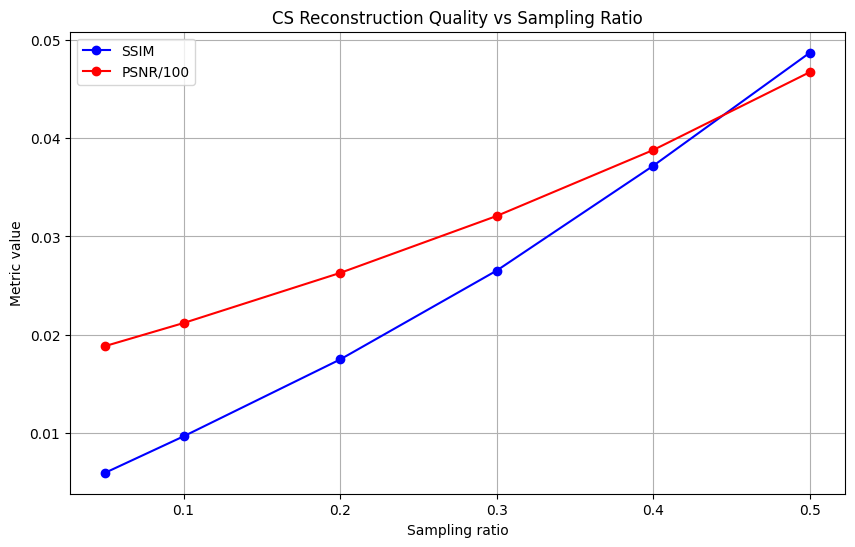

In [1]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
from scipy.optimize import minimize
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
import os

# Global variables needed by the optimizer
nx = ny = None  # Will be set from image dimensions
ri = None       # Will be set for each sampling ratio
b = None        # Will be set for each channel

# ---------------------------------------------------
# 2D DCT / IDCT
# ---------------------------------------------------
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# ---------------------------------------------------
# Evaluation function for L-BFGS-B
# ---------------------------------------------------
def objective(x):
    global nx, ny, ri, b
    x2 = x.reshape((nx, ny)).T
    Ax2 = idct2(x2)
    Ax = Ax2.T.flat[ri].reshape(b.shape)
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))
    return fx

def gradient(x):
    global nx, ny, ri, b
    x2 = x.reshape((nx, ny)).T
    Ax2 = idct2(x2)
    Ax = Ax2.T.flat[ri].reshape(b.shape)
    Axb = Ax - b
    
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb
    AtAxb2 = 2 * dct2(Axb2)
    return AtAxb2.T.ravel()

# ---------------------------------------------------
# Main CS Reconstruction
# ---------------------------------------------------
if __name__ == "__main__":
    # Check if image exists
    fileName = "image.jpg"
    if not os.path.exists(fileName):
        raise FileNotFoundError(f"Image file '{fileName}' not found. Please place the image in the same directory as this notebook.")
    
    # Load and verify image
    try:
        Xorig = imageio.imread(fileName)
        if len(Xorig.shape) != 3:
            raise ValueError("Image must be a color image (RGB)")
        ny, nx, nchan = Xorig.shape
        
        # Set global variables
        globals()['nx'] = nx
        globals()['ny'] = ny
        
    except Exception as e:
        print(f"Error loading image: {str(e)}")
        raise

    # Sampling ratios from 50% down to 5%
    sample_sizes = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]

    psnrList = []
    ssimList = []
    mseList = []

    # Create output directory if it doesn't exist
    output_dir = "reconstructed"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    Z = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
    masks = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]

    try:
        for i, s in enumerate(sample_sizes):
            print(f"\nProcessing sampling ratio {s:.2f}")
            k = round(nx * ny * s)
            globals()['ri'] = np.random.choice(nx * ny, k, replace=False)

            for j in range(nchan):
                X = Xorig[:, :, j].squeeze()

                Xm = 255 * np.ones(X.shape)
                Xm.T.flat[ri] = X.T.flat[ri]
                masks[i][:, :, j] = Xm

                globals()['b'] = X.T.flat[ri].astype(float)

                print(f"Channel {j+1}/{nchan}: Running L-BFGS-B optimization...")
                x0 = np.zeros(nx * ny)  # Initial guess
                res = minimize(objective, x0, method='L-BFGS-B', jac=gradient, 
                             options={'maxiter': 100, 'ftol': 1e-6})
                
                if not res.success:
                    print(f"Warning: Optimization did not converge: {res.message}")
                
                Xat = res.x.reshape(nx, ny).T
                Xa = idct2(Xat)
                Z[i][:, :, j] = np.clip(Xa, 0, 255).astype('uint8')

            # Save mask & reconstruction
            output_base = os.path.join(output_dir, os.path.splitext(fileName)[0])
            plt.imsave(f"{output_base}_Mask_{s:.2f}.jpg", masks[i])
            plt.imsave(f"{output_base}_Reconstructed_{s:.2f}.jpg", Z[i])

            # Compute metrics
            psnr_val = psnr(Xorig, Z[i], data_range=255)
            ssim_val = ssim(Xorig, Z[i], channel_axis=2)
            mse_val = mse(Xorig, Z[i])
            
            print(f"PSNR: {psnr_val:.2f} dB")
            print(f"SSIM: {ssim_val:.4f}")
            print(f"MSE: {mse_val:.2f}")
            
            psnrList.append(psnr_val)
            ssimList.append(ssim_val)
            mseList.append(mse_val)

        # Plot SSIM vs sampling ratio
        plt.figure(figsize=(10, 6))
        plt.plot(sample_sizes, ssimList, 'bo-', label='SSIM')
        plt.plot(sample_sizes, [p/100 for p in psnrList], 'ro-', label='PSNR/100')
        plt.xlabel("Sampling ratio")
        plt.ylabel("Metric value")
        plt.title("CS Reconstruction Quality vs Sampling Ratio")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_base}_metrics.jpg")
        plt.show()

    except Exception as e:
        print(f"Error during reconstruction: {str(e)}")
        raise

ValueError: num must be an integer with 1 <= num <= 8, not 9

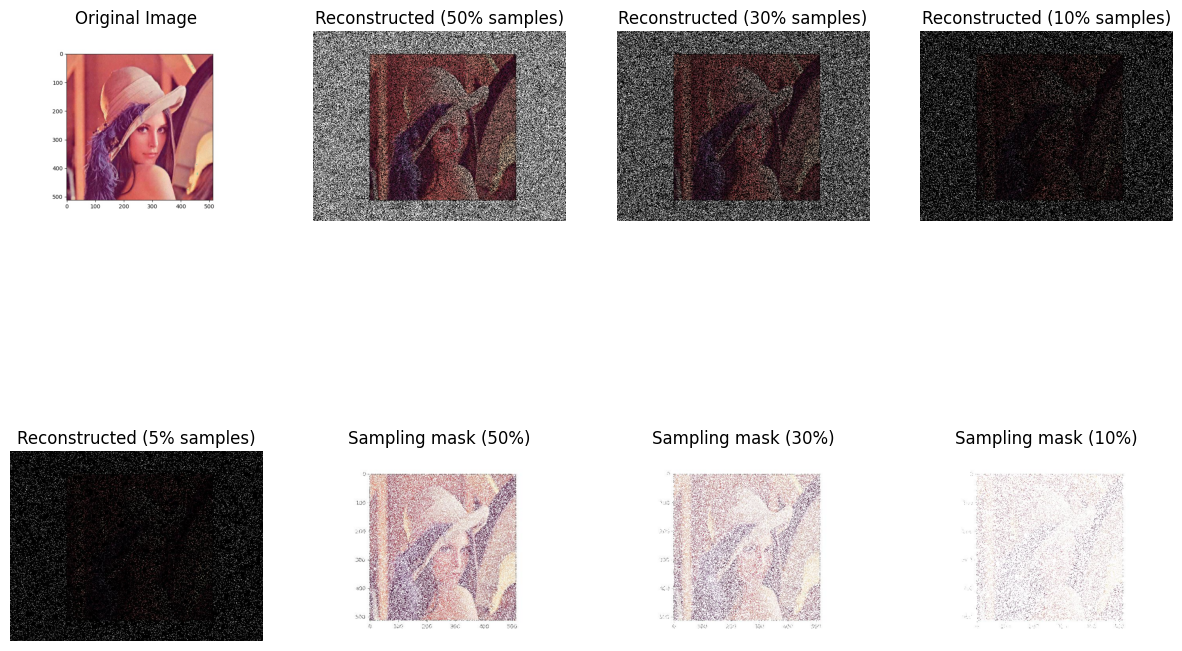

In [3]:
# Display original image and reconstructions
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 4, 1)
plt.imshow(Xorig)
plt.title('Original Image')
plt.axis('off')

# Show reconstructions at different sampling ratios
for i, s in enumerate([0.5, 0.3, 0.1, 0.05]):
    # Load and display reconstructed image
    img_path = os.path.join('reconstructed', f'image_Reconstructed_{s:.2f}.jpg')
    img = plt.imread(img_path)
    plt.subplot(2, 4, i+2)
    plt.imshow(img)
    plt.title(f'Reconstructed ({s*100:.0f}% samples)')
    plt.axis('off')
    
    # Load and display sampling mask
    mask_path = os.path.join('reconstructed', f'image_Mask_{s:.2f}.jpg')
    mask = plt.imread(mask_path)
    plt.subplot(2, 4, i+6)
    plt.imshow(mask)
    plt.title(f'Sampling mask ({s*100:.0f}%)')
    plt.axis('off')

plt.tight_layout()
plt.show()